In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class GranuleDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]  # Image path
        labels = self.data.iloc[idx, 1:].values.astype(float)  # d10, d50, d90
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels, dtype=torch.float32)


In [2]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])


In [11]:
from torch.utils.data import DataLoader, random_split

# Load the CSV file
dataset = GranuleDataset(csv_file="granules_dataset.csv", transform=data_transforms)

# Split dataset
train_size = int(0.75 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"train size = {train_size}, validation size = {val_size}, test size = {test_size}")


train size = 1562, validation size = 208, test size = 313


In [4]:
from torchvision.models import resnet50
import torch.nn as nn

# Load pretrained ResNet50
model = resnet50(pretrained=True)

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # Output: d10, d50, d90


/home/yasser/miniconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yasser/miniconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import torch.optim as optim

# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)                                                            


Epoch 1/20, Train Loss: 1.0674, Val Loss: 1.2688
Epoch 2/20, Train Loss: 0.3578, Val Loss: 1.3749
Epoch 3/20, Train Loss: 0.3273, Val Loss: 0.4441
Epoch 4/20, Train Loss: 0.3297, Val Loss: 1.0377
Epoch 5/20, Train Loss: 0.3334, Val Loss: 1.1559
Epoch 6/20, Train Loss: 0.2882, Val Loss: 0.3231
Epoch 7/20, Train Loss: 0.3110, Val Loss: 0.4463
Epoch 8/20, Train Loss: 0.2887, Val Loss: 3.4717
Epoch 9/20, Train Loss: 0.3170, Val Loss: 3.2446
Epoch 10/20, Train Loss: 0.2920, Val Loss: 1.0554
Epoch 11/20, Train Loss: 0.2645, Val Loss: 0.7367
Epoch 12/20, Train Loss: 0.2672, Val Loss: 0.3328
Epoch 13/20, Train Loss: 0.2847, Val Loss: 0.9727
Epoch 14/20, Train Loss: 0.3049, Val Loss: 0.7360
Epoch 15/20, Train Loss: 0.2836, Val Loss: 0.9618
Epoch 16/20, Train Loss: 0.2625, Val Loss: 0.7964
Epoch 17/20, Train Loss: 0.3141, Val Loss: 0.9112
Epoch 18/20, Train Loss: 0.2408, Val Loss: 0.4284
Epoch 19/20, Train Loss: 0.2559, Val Loss: 0.2368
Epoch 20/20, Train Loss: 0.2805, Val Loss: 0.3051


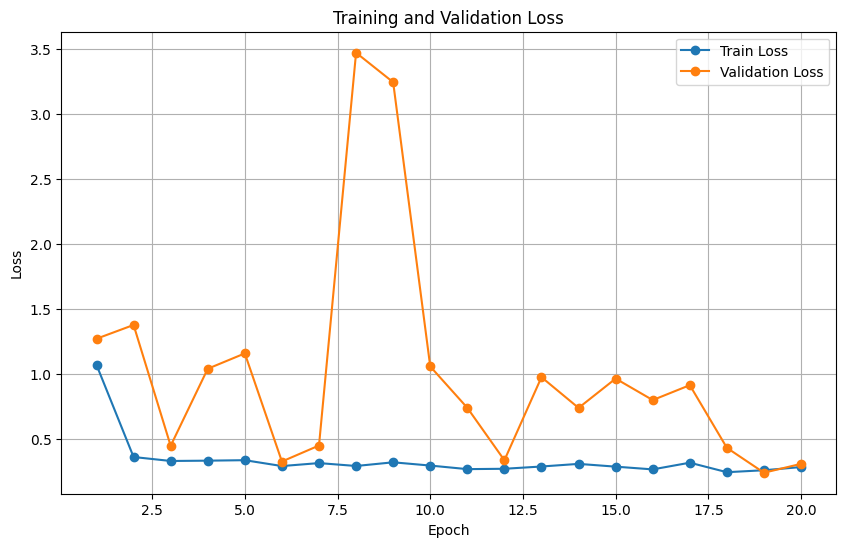

In [6]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def train_model_with_plots(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the model with plots
train_model_with_plots(model, train_loader, val_loader, criterion, optimizer, epochs=20)



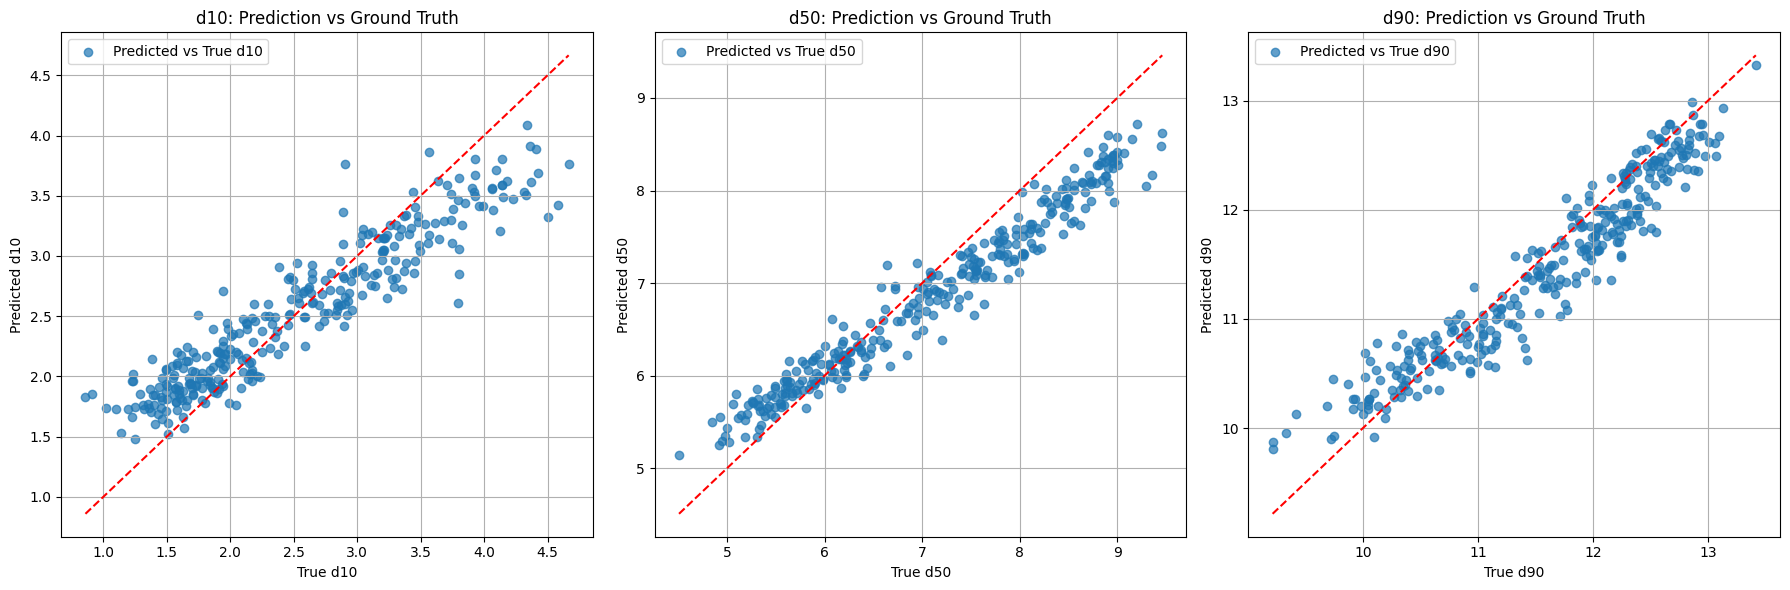

In [7]:
import numpy as np
def plot_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Plot ground truth vs predictions for d10, d50, and d90
    metrics = ['d10', 'd50', 'd90']
    plt.figure(figsize=(18, 6))

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.scatter(all_labels[:, i], all_predictions[:, i], alpha=0.7, label=f'Predicted vs True {metrics[i]}')
        plt.plot([all_labels[:, i].min(), all_labels[:, i].max()],
                 [all_labels[:, i].min(), all_labels[:, i].max()], 'r--')  # Diagonal line
        plt.xlabel(f'True {metrics[i]}')
        plt.ylabel(f'Predicted {metrics[i]}')
        plt.title(f'{metrics[i]}: Prediction vs Ground Truth')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    return all_labels, all_predictions

# Plot predictions
all_labels, all_predictions = plot_predictions(model, test_loader)


In [8]:
import pandas as pd

# Create a pandas DataFrame
def create_results_table(all_labels, all_predictions, metrics):
    """
    Create a pandas DataFrame showing true values and predictions for each metric.

    Args:
        all_labels (numpy array): True values for d10, d50, d90.
        all_predictions (numpy array): Predicted values for d10, d50, d90.
        metrics (list): List of metric names (e.g., ['d10', 'd50', 'd90']).

    Returns:
        pd.DataFrame: A DataFrame with true and predicted values side by side.
    """
    # Create a dictionary for the DataFrame
    data = {}
    for i, metric in enumerate(metrics):
        data[f"True {metric}"] = all_labels[:, i]
        data[f"Predicted {metric}"] = all_predictions[:, i]

    # Create the DataFrame
    results = pd.DataFrame(data)
    return results

# Define metric names
metrics = ['d10', 'd50', 'd90']

# Generate the results table
results_table = create_results_table(all_labels, all_predictions, metrics)

# Display the table
print(results_table)

# Save to a CSV file if needed
results_table.to_csv("predictions_results.csv", index=False)


     True d10  Predicted d10  True d50  Predicted d50   True d90  \
0    1.387122       2.143383  5.764739       6.162044  10.610902   
1    2.925862       2.629778  7.640902       7.065804  12.042244   
2    3.685373       3.287797  8.459264       7.861219  12.538332   
3    2.476169       2.646186  7.213021       6.879675  11.855368   
4    1.946592       2.707404  7.479537       7.208776  11.899157   
..        ...            ...       ...            ...        ...   
308  1.854374       1.904789  5.984907       5.957980  10.830919   
309  3.350069       2.725728  8.032965       7.325240  12.397694   
310  2.742650       2.796754  7.796780       7.369999  12.039516   
311  1.933370       1.935040  5.716978       5.809710  10.377589   
312  2.736197       2.523992  8.020948       7.319189  12.282957   

     Predicted d90  
0        10.773835  
1        11.627628  
2        12.228444  
3        11.393117  
4        11.842244  
..             ...  
308      10.674198  
309      12.018

In [9]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

evaluate_model(model, test_loader, criterion)


Test Loss: 0.3085


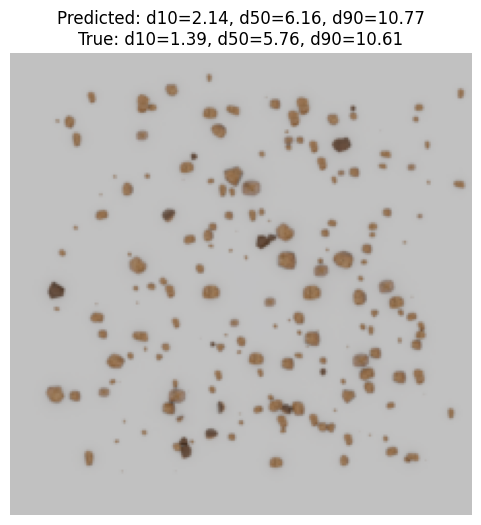

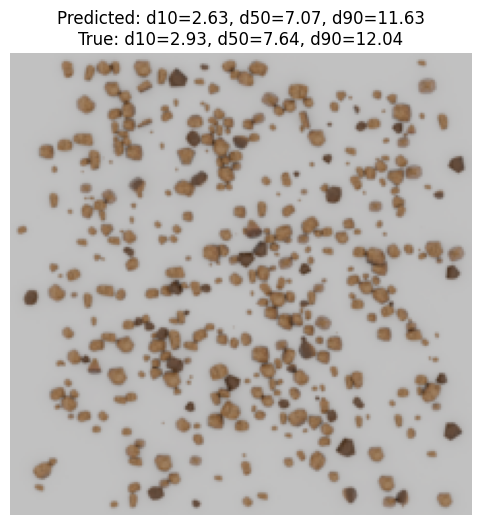

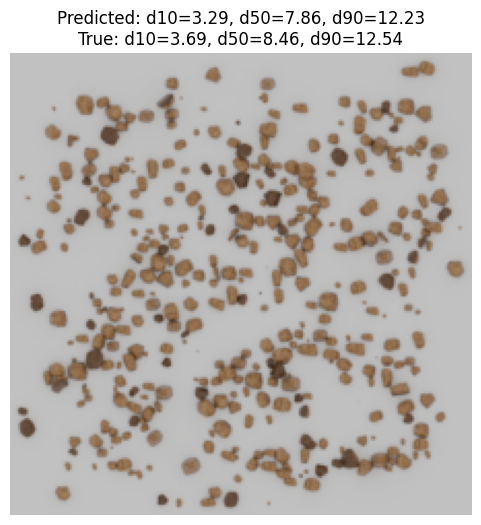

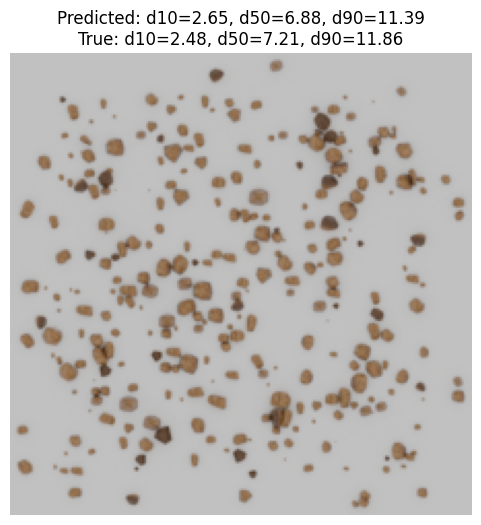

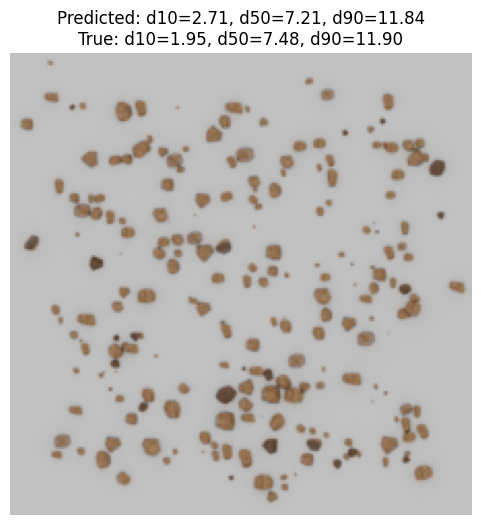

In [10]:
def visualize_test_predictions(model, test_loader, num_images=5):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            for i in range(len(images)):
                if images_shown >= num_images:
                    return

                # Convert image tensor to numpy
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])  # Undo normalization
                img = np.clip(img, 0, 1)

                # Predictions and labels
                pred = outputs[i].cpu().numpy()
                true = labels[i].cpu().numpy()

                # Plot the image
                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Predicted: d10={pred[0]:.2f}, d50={pred[1]:.2f}, d90={pred[2]:.2f}\n"
                          f"True: d10={true[0]:.2f}, d50={true[1]:.2f}, d90={true[2]:.2f}")
                plt.show()

                images_shown += 1

# Visualize test predictions
visualize_test_predictions(model, test_loader, num_images=5)
